# Movie Box Office revenue predictor


## Authors: Christopher Budd, Mustafa Syed, and Jayant Varma 

### Objective: 
To predict the revenue generated by a movie given its other featuers such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, etc.



**Dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing** Kindly download the dataset on your local machine and run it accordingly (see how we ran it under 'Loading the dataset')

# Movies daily updated dataset description:

**Attributes for the dataset:**
The below attributes are copied **AS IS** from the original dataset website https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data 

1. id	--> TMDB id

2. title	--> Title of the movie

3. genres	--> Genres are separated by'-'

4. original_language	--> The language the movie was made in

5. overview	    --> short description of movie

6. popularity   --> TMDB metric, in depth description can be found here, https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/discussion/400671 

7. production_companies	--> '-' separated production company

8. release_date     --> movie release date

9. budget	--> budget of the movie

10. revenue	    --> Revenue generated by the movie

11. runtime	    --> duration of the movie

12. status	--> status (Released, or planned, or other)

13. tagline	    --> tagline

14. vote_average	--> average of votes given by tmdb users

15. vote_count	       --> vote counts

16. credits	        --> '-' separated cast if movie

17. keywords	    --> '-' separated keywords that desciption of movie

18. poster_path	    --> poster image

19. backdrop_path	--> background images

20. recommendations --> '-' separated recommended movie id


**Missing values:** There exist missing values in multiple features of the above dataset as we'll soon see


**Duplicated values:** 
We'll see if there exist any duplicated values in the dataset

# 1: Looking at the big picture, framing the problem, and business practicality

### Frame the problem
1. Supervised learning – training examples are labeled.
2. A regression task – predict a value (Revenue).
3. Batch learning 
    - Small data set
    - No continuous flow of data coming into the system
    - No need to adjust to changing data rapidly

### Big Picture/Business objective:
At the end of the day every business wants to know how much revenue they can generate given the all production inputs. Our project solves this problem for the movie industry. See objective below.

### Objective: 
To predict the revenue generated by a movie given its other featuers such as plot keywords, cast, budget, release dates, languages, production companies, countries, TMDB vote counts and vote averages, reviews, and recommendations.


# Initial set up

In [27]:
# Import libraries

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [28]:
movies = pd.read_csv(".\movies.csv") 
# Please note: The file is massive, and could not be referred online. You MUST download the file on your local machine from https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=drive_link (MAKE SURE YOU ONLY USE YOUR YORK UNIVERSITY GOOGLE ACCOUNT!!!)

# 2 First impressions on the dataset, graphs of the EDA, and patterns found


Note: These imply it would be better if you use only the dataset from January 1985 until Nov. 5th 2023??

In [29]:
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...,/qnqGbB22YJ7dSs4o6M7exTpNxPz.jpg,/m8JTwHFwX7I7JY5fPe4SjqejWag.jpg,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...,/cvsXj3I9Q2iyyIo95AecSd1tad7.jpg,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,965839-267805-943822-842942-1035806-823999-107...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722654,156107,Hitlers Hantlangare - Mengele,NaN,sv,NaN,0.600,NaN,2004-01-01,0.0,0.0,0.0,Released,NaN,0.000,0.0,NaN,NaN,NaN,NaN,NaN
722655,283376,Ruslan Provodnikov vs Chris Algieri,NaN,en,"If Ruslan Provodnikov is as he calls himself ""...",0.600,NaN,2014-06-14,0.0,0.0,75.0,Released,NaN,0.000,0.0,NaN,NaN,NaN,NaN,NaN
722656,959540,The Grinning Granger,Western,en,The Grinning Granger is a 1920 Western short,0.600,Universal Film Manufacturing Company,1920-10-09,0.0,0.0,20.0,Released,NaN,0.000,0.0,Hoot Gibson-Dorothy Wood-Kansas Moehring-Jim C...,NaN,NaN,NaN,NaN
722657,505258,Prole,NaN,en,Follows a group of Spanish-speaking men as the...,0.600,NaN,NaN,0.0,0.0,0.0,Released,NaN,0.000,0.0,NaN,NaN,/8GglPBwM95QEaqsMr7CLEhZrB9g.jpg,NaN,NaN


#### Use head() to look at the first 5 rows

In [30]:
movies.head()


,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...,/qnqGbB22YJ7dSs4o6M7exTpNxPz.jpg,/m8JTwHFwX7I7JY5fPe4SjqejWag.jpg,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...,/cvsXj3I9Q2iyyIo95AecSd1tad7.jpg,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,965839-267805-943822-842942-1035806-823999-107...


#### Use describe() method to see a summary of the numerical attributes.


Note: 
- Since count of id = count of budget and count of revenue, we know our data for predicting revenue is complete in a one to one mapping between id and revenue. The data rows exist, however the values may need preprocessing
- Parts of this data make little sense, for example, the maximum run time is 1.5 years if we take the unit to be in seconds. This clearly means, a lot of data cleaning, and preprocessing is required.
- Revenue could be negative, as seen from the 'min' case.

In [31]:
movies.describe()

,id,popularity,budget,revenue,runtime,vote_average,vote_count
count,722659.000000,722659.000000,7.226590e+05,7.226590e+05,6.882360e+05,722659.000000,722659.000000
mean,526918.186672,1.824704,3.961943e+05,9.867637e+05,1.989784e+02,2.444297,27.767933
std,253175.268512,20.599567,8.179416e+06,2.025126e+07,8.582673e+04,3.175986,383.783529
min,2.000000,0.600000,0.000000e+00,-1.200000e+01,0.000000e+00,0.000000,0.000000
25%,328933.500000,0.600000,0.000000e+00,0.000000e+00,5.000000e+00,0.000000,0.000000
50%,533367.000000,0.600000,0.000000e+00,0.000000e+00,5.000000e+01,0.000000,0.000000
75%,737826.500000,1.295000,0.000000e+00,0.000000e+00,9.000000e+01,5.600000,2.000000
max,968161.000000,8763.998000,5.000000e+09,2.920357e+09,5.050505e+07,10.000000,33262.000000


#### Use info() to get a quick description of the data, the total number of rows, each attribute’s type, and the number of non-null values.

In [32]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722659 entries, 0 to 722658
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    722659 non-null  int64  
 1   title                 722653 non-null  object 
 2   genres                511964 non-null  object 
 3   original_language     722659 non-null  object 
 4   overview              604169 non-null  object 
 5   popularity            722659 non-null  float64
 6   production_companies  337219 non-null  object 
 7   release_date          670566 non-null  object 
 8   budget                722659 non-null  float64
 9   revenue               722659 non-null  float64
 10  runtime               688236 non-null  float64
 11  status                722659 non-null  object 
 12  tagline               108228 non-null  object 
 13  vote_average          722659 non-null  float64
 14  vote_count            722659 non-null  float64
 15  

In [33]:
movies["title"].value_counts()

title
Home                                            108
Alone                                            76
Mother                                           66
Untitled                                         63
The Gift                                         62
                                               ... 
Moksha: Salvation                                 1
Martin's Pink Pickle                              1
Tehranto                                          1
Superdimensional Romanesque Samy: Missing 99      1
Gising Sining                                     1
Name: count, Length: 575346, dtype: int64

Note: The above implies that there exists only 575346 titled movies out of 722659 instances in the dataset. 

In [34]:
corr_matrix = movies.corr(numeric_only=True)
corr_matrix

,id,popularity,budget,revenue,runtime,vote_average,vote_count
id,1.000000,-0.030616,-0.065876,-0.071936,0.000680,-0.391986,-0.103705
popularity,-0.030616,1.000000,0.145329,0.184511,-0.000074,0.062357,0.153137
budget,-0.065876,0.145329,1.000000,0.496183,-0.000050,0.055210,0.435458
revenue,-0.071936,0.184511,0.496183,1.000000,-0.000048,0.065695,0.768395
runtime,0.000680,-0.000074,-0.000050,-0.000048,1.000000,-0.001179,-0.000076
vote_average,-0.391986,0.062357,0.055210,0.065695,-0.001179,1.000000,0.100127
vote_count,-0.103705,0.153137,0.435458,0.768395,-0.000076,0.100127,1.000000


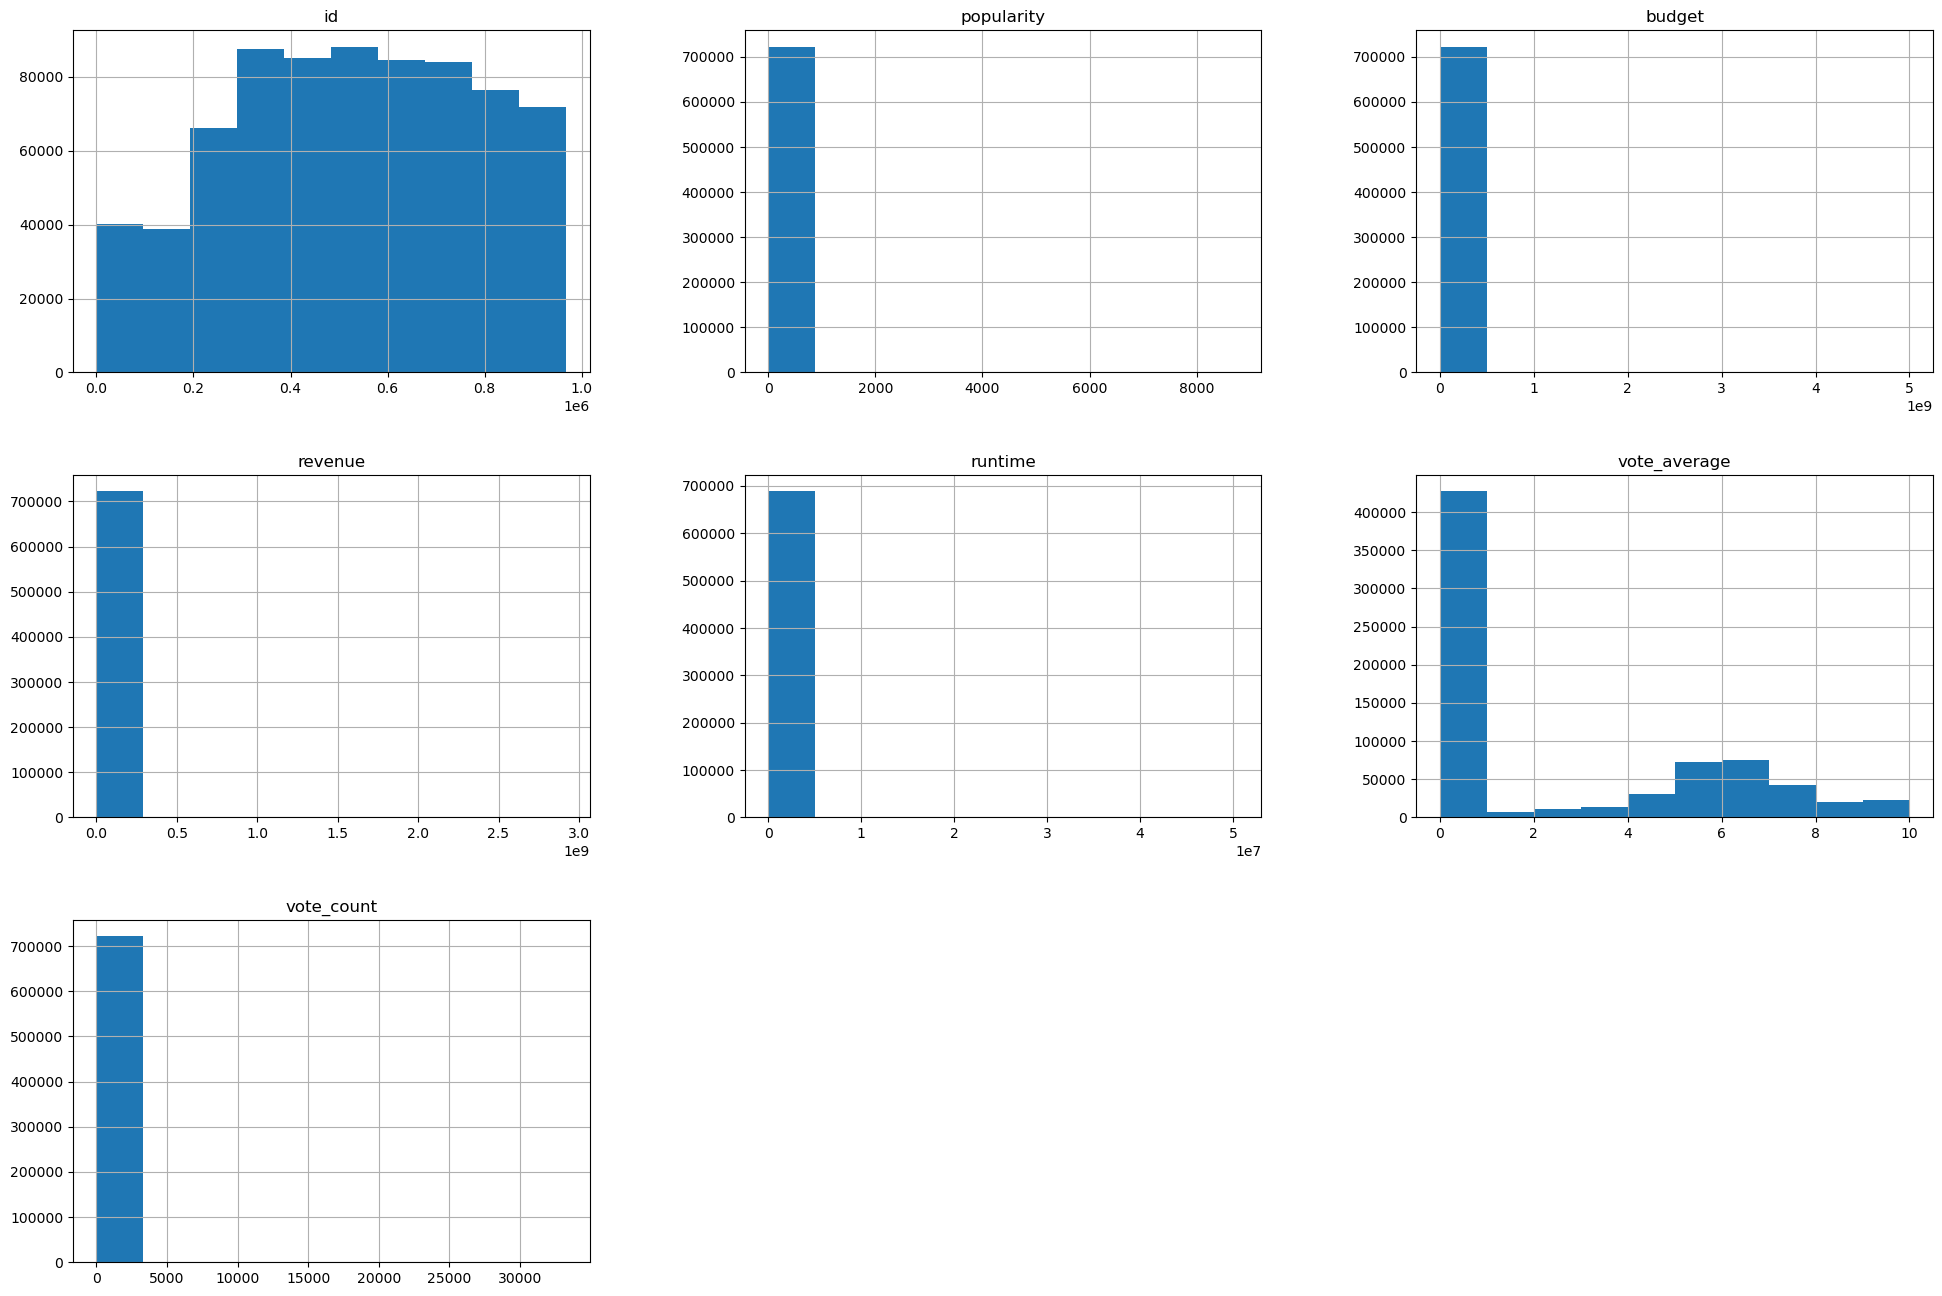

In [35]:
movies.hist(figsize=(24, 16))
plt.show()

In [36]:
# Check for correlation between attributes using sns.pairplot.
#sns.pairplot(movies)

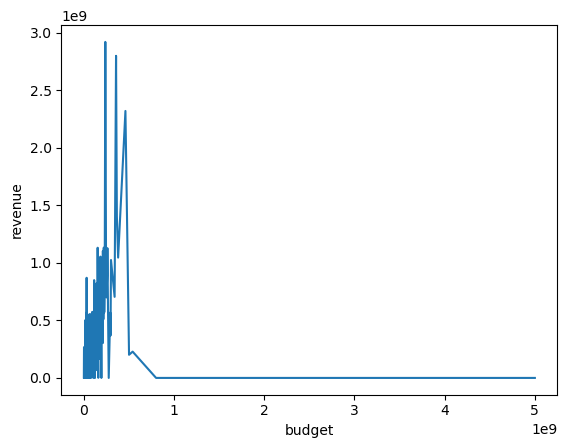

In [37]:
# Plot budget vs. revenue generated

budgetVsRevenue = sns.lineplot(x="budget", y="revenue", data=movies, errorbar=None)

As you can see, it is not necessarily the case that higher the budget, the more revenue is generated

Text(0, 0.5, 'revenue')

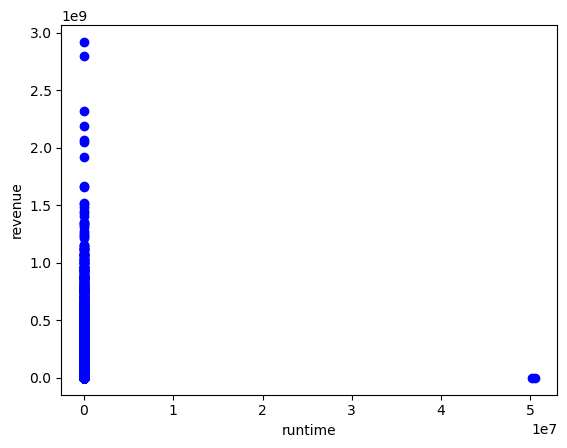

In [38]:
X = movies["runtime"]
y = movies["revenue"]
# Plot points
fig, pl = plt.subplots()
pl.scatter(X, y, color = 'b')
plt.xlabel("runtime")
plt.ylabel("revenue")

clearly, we need to get rid of the right most value as it is ruining the data plot. We need feature scaling after that.

In [39]:
# Check for correlation between attributes using sns.pairplot.
# sns.pairplot(movies)

# 3 Preprocessing: Preparing data for Machine Learning tasks


## 3.1. - Data cleaning

## 3.2. - Encoding

## 3.3. - Feature scaling

# 4 Training and evaluation of 3 Machine Learning Algorithms, findings, and result comparison

## 4.1. - Training of 3 ML algorithms
- Algorithm 1: 
- Algorithm 2:
- Algorithm 3: 



## 4.2. - Analysis of findings



## 4.3. - Comparison of results

# 5 - Three Graphs for the best performance algorithm

# 6 Limitations of the project

# Appendix 1:

Empty unless we used someone else's code, then we cite it here

# Appendix 2: 

### Github repository link: https://github.com/Jayant1Varma/Movie-Box-Office-predictor.git 

**Original dataset citation: The dataset used was https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data . However, this dataset is updated daily, but we used this dataset as it was available on November 5th 2023**

**You can find the exact dataset we used here: https://drive.google.com/file/d/1uPtHyqpAKkqZUpft8A0FPVXPR2iT32SN/view?usp=sharing**